## U shape PHP dynamics with multiple liquid slugs - with heat transfer

## wall heat equation

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta + W_{evaporator} + H_{condenser}(\theta_{condenser} - \theta_{wall}) + H_{fluid}(\theta_{fluid} - \theta_{wall})$

## liquid heat equation

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta + H_{fluid}(\theta_{wall} - \theta_{fluid})$

## dynamics equations
We solve a set of governing equations:

1. Momentum equation:
 ## $\frac{\mathrm{d}^{2} X_{p}}{\mathrm{d} \tau^{2}}+32 \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau}+\omega_{0}^{2} X_{p}=\wp\left(P_{1}-P_{2}\right)$
 
2. Perfect gas law combined with first law of thermodynamics:

 ## $M_{i}=P_{i}^{1 / \gamma}L_{i}$
 
 ## $\theta_{i}=P_{i}^{(\gamma-1) / \gamma}$
 


3. The phase change relations between the mass of vapor and the heat transfer from the wall
 ## $\frac{\mathrm{d} M_{i}}{\mathrm{d} \mathcal{T}}=\int_{X_{start}}^{X_{end}} H_{vapor} (\theta_{wall} - \theta_{vapor}) dX$

 


## nucleate boiling

$nucleatenum = 2$ is the number of nucleation sites. It is distributed randomly for every start time.

$\Delta t = 0.1$ is the time interval for nucleations, for now it is uniform for all nucleation sites, can be modified later on.

$Δθthreshold = 0.01$ is the super heat threshold.

So it means that at time $\Delta t$,  $2\Delta t$,  $3\Delta t$ ... and so on. It will check if the nucleation sites are in the liquid slug region and if the superheat is fulfilled. if so, it will reslease one or several $L=0.02, P=1$ new vapor bubbles

In [86]:
@time using Plots
pyplot()

  0.001535 seconds (588 allocations: 31.875 KiB)


Plots.PyPlotBackend()

In [87]:
using LinearAlgebra

In [88]:
@time using DifferentialEquations

  0.001453 seconds (468 allocations: 25.797 KiB)


In [89]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing

include("Boiling.jl")
using ..Boiling

cd(dirname(pwd()))
cd("src") 

In [90]:
function getoneXarrayindex(X,Xarray)
    for i = 1:length(Xarray)
        if (X >= Xarray[i] && X <= Xarray[i+1])
            return i
        end
    end
    
    return length(Xarray)
end

getoneXarrayindex (generic function with 1 method)

In [91]:
function getsuperheat(Xstation,sys)

    wallindex = getoneXarrayindex(Xstation,sys.wall.Xarray)
    liquidindex = sys.mapping.walltoliquid[wallindex]

    Δθ = sys.wall.θarray[wallindex] - sys.liquid.θarrays[liquidindex[1]][liquidindex[2]]

    return Δθ
end

getsuperheat (generic function with 1 method)

## Parameters of the PHP

In [92]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];

    θinitial=1.0
    θ  = 0.15;
    θe = 1 + θ;
    θc = 1 - θ;

    
    He  = 3000.0; # H for wall and vapor
    Hc  = 3000.0; # depreciated
    Hwc = 3000.0; # H for wall and condenser liquid
    Hₗ   =  3000.0; # liquid wall heat transfer coeffcient

    
    X0 = 0.5;

    γ = 1.4;

In [93]:
    
    d = 1/30 # dimensionless diameter
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 
    closedornot = true

true

In [94]:
    nucleatenum = 2
    Xstations = sort(rand(nucleatenum).*L)
    Δt = 0.05

0.05

## Pipe definition

In [95]:
tube = Tube(d,L,L2D,angle,closedornot)

Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, true)

## Evaporator and condenser definition

In [96]:
Xe = map(tuple, [0.0], [2.0])
# Xe = map(tuple, [0.0,3.0], [1.0,4.0])
We = [200.0]
evap = Evaporator(He,θe,Xe,We)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0])

In [97]:
Xc = map(tuple, [2.0], [4.0])
# Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc,Hwc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0)

## Vapor plug and liquid slug initialization

In [98]:
N=500
X0 = [(3.0, 0.2),(1.0,2.0)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
ρₗ = 1000
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(γ,Hₗ,ρₗ,ω0,℘,X0,dXdt0,Xarrays,θarrays)

Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(3.0, 0.2), (1.0, 2.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[3.0, 3.0080536912751676, 3.0161073825503357, 3.0241610738255034, 3.032214765100671, 3.040268456375839, 3.0483221476510067, 3.0563758389261744, 3.064429530201342, 3.07248322147651  …  0.12751677852348994, 0.13557046979865772, 0.1436241610738255, 0.15167785234899328, 0.1597315436241611, 0.16778523489932887, 0.17583892617449665, 0.18389261744966443, 0.1919463087248322, 0.2], [1.0, 1.0080645161290323, 1.0161290322580645, 1.0241935483870968, 1.032258064516129, 1.0403225806451613, 1.0483870967741935, 1.0564516129032258, 1.064516129032258, 1.0725806451612903  …  1.9274193548387097, 1.935483870967742, 1.9435483870967742, 1.9516129032258065, 1.9596774193548387, 1.967741935483871, 1.9758064516129032, 1.9838709677419355, 1.9919354838709677, 2.0]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1

In [99]:
P = [1.0,2.0]; # closed end
# P = [1.0,1.0]; open end
δ = 0.05*P;
vapors=Vapor(γ,P,δ)

Vapor(1.4, [1.0, 2.0], [0.05, 0.1])

In [100]:
α = 1 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray)

Wall(1.0, 0.05, [1.6473149126517725, 1.936771806520861], [0.0, 0.008016032064128256, 0.01603206412825651, 0.02404809619238477, 0.03206412825651302, 0.04008016032064128, 0.04809619238476954, 0.056112224448897796, 0.06412825651302605, 0.07214428857715431  …  3.9278557114228456, 3.935871743486974, 3.943887775551102, 3.9519038076152304, 3.9599198396793587, 3.967935871743487, 3.975951903807615, 3.9839679358717435, 3.9919839679358717, 4.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [101]:
# struct Mapping
#     walltoliquid::Array{Tuple{Int64,Int64},1}
#     liquidtowall::Array{Array{Int64,1},1}
# end

In [102]:
walltoliquid, liquidtowall = constructmapping(Xarrays,Xwallarray,closedornot,L)
mapping = Mapping(walltoliquid,liquidtowall)

Mapping(Tuple{Int64,Int64}[(1, 126), (1, 126), (1, 127), (1, 128), (1, 129), (1, 130), (1, 131), (1, 132), (1, 133), (1, 134)  …  (1, 117), (1, 118), (1, 119), (1, 120), (1, 121), (1, 122), (1, 123), (1, 124), (1, 125), (1, 125)], Array{Int64,1}[[376, 377, 378, 379, 380, 381, 382, 383, 384, 385  …  17, 18, 19, 20, 21, 22, 23, 24, 25, 26], [126, 127, 128, 129, 130, 131, 132, 133, 134, 135  …  242, 243, 244, 245, 246, 247, 248, 249, 250, 251]])

## Construct the system

In [103]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping)

PHPSystem(Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, true), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(3.0, 0.2), (1.0, 2.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[3.0, 3.0080536912751676, 3.0161073825503357, 3.0241610738255034, 3.032214765100671, 3.040268456375839, 3.0483221476510067, 3.0563758389261744, 3.064429530201342, 3.07248322147651  …  0.12751677852348994, 0.13557046979865772, 0.1436241610738255, 0.15167785234899328, 0.1597315436241611, 0.16778523489932887, 0.17583892617449665, 0.18389261744966443, 0.1919463087248322, 0.2], [1.0, 1.0080645161290323, 1.0161290322580645, 1.0241935483870968, 1.032258064516129, 1.0403225806451613, 1.0483870967741935, 1.0564516129032258, 1.064516129032258, 1.0725806451612903  …  1.9274193548387097, 1.935483870967742, 1.94354838

In [104]:
typeof(sys0)

PHPSystem

## Construct U for wall heat function

## construct state vector U

In [105]:
δ

2-element Array{Float64,1}:
 0.05
 0.1 

In [106]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); wallθtovec(sys0.wall.θarray); liquidθtovec(sys0.liquid.θarrays)];

In [107]:
# plot([sys0.wall.Xarray],[sys0.wall.θarray], title="initial temperature condition", labels = "θ", xlabel="X", ylabel="θ")

## Solve the constructed ODE for U

### propagation function

In [108]:
function dfdt(u,p,t)

        indexes = Int64[]
        θliquidtemp = Array[]

        for i = 1:length(u)
            if abs(u[i]+1e10) <= 10^(-1)
                push!(indexes,i)
            end
        end

        # trim u first verrrrry important!!!!!!!
        Xp,dXdt,M,δ = vectoXMδ(u[1:indexes[1]-1])
        modX!(Xp,p.tube.L)
        u[1:indexes[1]-1] = XMδtovec(Xp,dXdt,M,δ)
    
#     println(u[1:indexes[1]-1] )
    
    newsys = getcurrentsys(u,p)
    
    dynamicsdu = dynamicsmodel(u[1:indexes[1]-1],newsys)
    
    
    
    duwalltemp = wallmodel(u[indexes[1]+1:indexes[2]-1],newsys)
    walldu = duwallθtovec(duwalltemp)
    
    
    
    for i = 1:length(indexes)-2
    push!(θliquidtemp, u[indexes[i+1]+1:indexes[i+2]-1])
    end
    push!(θliquidtemp, u[indexes[end]+1:end])
    duliquidtemp = zero.(deepcopy(θliquidtemp))
    duliquidtemp = liquidmodel(θliquidtemp,newsys)
    liquiddu = duliquidθtovec(duliquidtemp)
    
    du = [dynamicsdu;walldu;liquiddu]

    return(du)

end

dfdt (generic function with 1 method)

### condition

In [109]:
(mod(0.050001,0.05) < 1e-7)

false

In [110]:
function condition(u,t,integrator)
    return (abs(mod(t,0.1)-0.1) < 1e-7) || mod(t,0.1) < 1e-7
end

condition (generic function with 1 method)

### affect! (with boundary conditions)

In [111]:
p

PHPSystem(Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, true), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.0, 2.0), (3.0, 0.2)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[1.0, 1.0080645161290323, 1.0161290322580645, 1.0241935483870968, 1.032258064516129, 1.0403225806451613, 1.0483870967741935, 1.0564516129032258, 1.064516129032258, 1.0725806451612903  …  1.9274193548387097, 1.935483870967742, 1.9435483870967742, 1.9516129032258065, 1.9596774193548387, 1.967741935483871, 1.9758064516129032, 1.9838709677419355, 1.9919354838709677, 2.0], [3.0, 3.0080536912751676, 3.0161073825503357, 3.0241610738255034, 3.032214765100671, 3.040268456375839, 3.0483221476510067, 3.0563758389261744, 3.064429530201342, 3.07248322147651  …  0.12751677852348994, 0.13557046979865772, 0.1436241610738

In [112]:
sys0.tube.d

0.03333333333333333

In [113]:
function affect!(integrator)
#     println("hahhaha")
    Δθthreshold = 0.01
    
    p = deepcopy(getcurrentsys(integrator.u,integrator.p))
    
    for i = 1:length(p.wall.Xstations)
        
        if ifamong(p.wall.Xstations[i], p.liquid.Xp)
            Δθ = getsuperheat(p.wall.Xstations[i],p)
            if Δθ > Δθthreshold
                p = nucleateboiling(p,(p.wall.Xstations[i]-p.tube.d/2,p.wall.Xstations[i]+p.tube.d/2),1.0) # p need to be given from energy equation
            end
        end
        
                

        
    end
    
    Lvaporplug = XptoLvaporplug(p.liquid.Xp,p.tube.L,p.tube.closedornot)
    M = p.vapor.P.^(1/p.vapor.γ).* Lvaporplug
    
    unew=[XMδtovec(p.liquid.Xp,p.liquid.dXdt,M,p.vapor.δ); wallθtovec(p.wall.θarray); liquidθtovec(p.liquid.θarrays)];
        
#     set_u!(integrator,  unew)
    resize!(integrator.u,length(unew))
    integrator.u = deepcopy(unew)
    

end

affect! (generic function with 1 method)

In [114]:
cb =  DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])

In [130]:
tstep=4e-5

p = sys0
tspan = (0.0, 0.2);
prob = ODEProblem(dfdt, u, tspan, p)

integrator = init(prob, RK4(), dt=tstep,adaptive=false);


# sol = solve(prob, RK4(), dt=tstep);
# sol = solve(prob, RK4(), adaptive=false,dt=tstep,callback=cb);

# step!(integrator)
solve!(integrator)



retcode: Success
Interpolation: 3rd order Hermite
t: 5001-element Array{Float64,1}:
 0.0                   
 4.0e-5                
 8.0e-5                
 0.00012000000000000002
 0.00016               
 0.0002                
 0.00024               
 0.00028000000000000003
 0.00032               
 0.00036               
 0.0004                
 0.00044               
 0.00048               
 ⋮                     
 0.19956000000001842   
 0.19960000000001843   
 0.19964000000001844   
 0.19968000000001845   
 0.19972000000001847   
 0.19976000000001848   
 0.1998000000000185    
 0.1998400000000185    
 0.19988000000001852   
 0.19992000000001853   
 0.19996000000001854   
 0.2                   
u: 5001-element Array{Array{Float64,1},1}:
 [3.0, 0.2, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.3125365696122209  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                                                                                                                                  

In [131]:
step!(integrator)

In [132]:
string("θliquid ",1)

"θliquid 1"

In [133]:
sol = integrator.sol
sysfinal = getcurrentsys.(sol.u,[sys0])

5002-element Array{PHPSystem,1}:
 PHPSystem(Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, true), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(3.0, 0.2), (1.0, 2.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[3.0, 2.9812080536912755, 2.9624161073825506, 2.9436241610738256, 2.9248322147651007, 2.906040268456376, 2.887248322147651, 2.868456375838926, 2.849664429530201, 2.8308724832214764  …  0.36912751677852357, 0.3503355704697988, 0.33154362416107397, 0.31275167785234914, 0.29395973154362404, 0.27516778523489926, 0.25637583892617444, 0.2375838926174496, 0.2187919463087248, 0.2], [1.0, 1.0080645161290323, 1.0161290322580645, 1.0241935483870968, 1.032258064516129, 1.0403225806451613, 1.0483870967741935, 1.0564516129032258, 1.064516129032258, 1.0725806451612903  …  1.927419354838

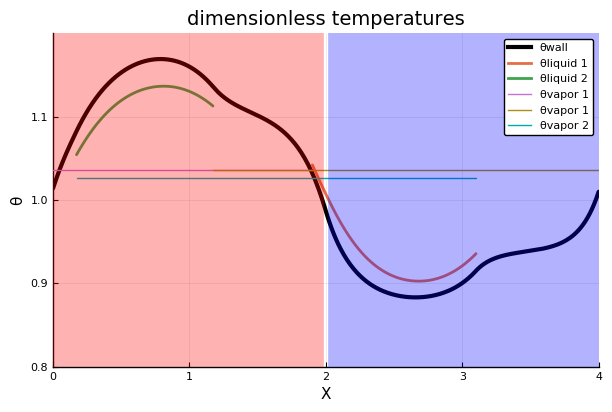

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\OneDThermalFlow\src\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\cc8wh\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\OneDThermalFlow\\src\\tmp.gif")
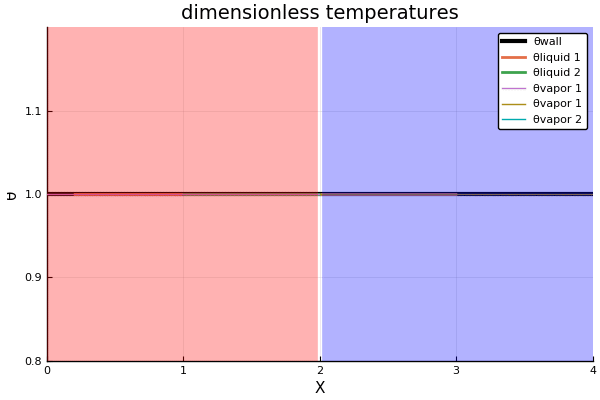

In [134]:
# closed loop plot
@gif for i=1:size(sol,2)
    
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    Xp = sysfinal[i].liquid.Xp
    
    p = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray], linewidth=3, color = [:black], labels = "θwall", xlabel="X", ylabel="θ", title=("dimensionless temperatures"),xlim=(0,4), ylim=(0.8,1.2))
    
    
    j=1
    while j <= length(Xp)
        plot!(p, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]], linewidth=2, labels = string("θliquid ",j))

        j += 1
    end

    j = 1
    plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
    plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))
    
    j = 2
    while j  <= length(θvapor) 
    
        plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
        j += 1
    end

    vline!( p, [collect(0:4:4)], color=[:red,:blue], width=390, alpha=[0.3,0.3],labels = "")
    
    end every 20

In [135]:
Xstations

2-element Array{Float64,1}:
 1.6473149126517725
 1.936771806520861 

In [136]:
Xarrays

2-element Array{Array{Float64,1},1}:
 [3.0, 3.0080536912751676, 3.0161073825503357, 3.0241610738255034, 3.032214765100671, 3.040268456375839, 3.0483221476510067, 3.0563758389261744, 3.064429530201342, 3.07248322147651  …  0.12751677852348994, 0.13557046979865772, 0.1436241610738255, 0.15167785234899328, 0.1597315436241611, 0.16778523489932887, 0.17583892617449665, 0.18389261744966443, 0.1919463087248322, 0.2]
 [1.0, 1.0080645161290323, 1.0161290322580645, 1.0241935483870968, 1.032258064516129, 1.0403225806451613, 1.0483870967741935, 1.0564516129032258, 1.064516129032258, 1.0725806451612903  …  1.9274193548387097, 1.935483870967742, 1.9435483870967742, 1.9516129032258065, 1.9596774193548387, 1.967741935483871, 1.9758064516129032, 1.9838709677419355, 1.9919354838709677, 2.0]     

In [137]:
Xarrays[1]

150-element Array{Float64,1}:
 3.0                
 3.0080536912751676 
 3.0161073825503357 
 3.0241610738255034 
 3.032214765100671  
 3.040268456375839  
 3.0483221476510067 
 3.0563758389261744 
 3.064429530201342  
 3.07248322147651   
 3.0805369127516777 
 3.0885906040268454 
 3.0966442953020135 
 ⋮                  
 0.11140939597315436
 0.11946308724832215
 0.12751677852348994
 0.13557046979865772
 0.1436241610738255 
 0.15167785234899328
 0.1597315436241611 
 0.16778523489932887
 0.17583892617449665
 0.18389261744966443
 0.1919463087248322 
 0.2                

In [138]:
Xarrays[2]

125-element Array{Float64,1}:
 1.0               
 1.0080645161290323
 1.0161290322580645
 1.0241935483870968
 1.032258064516129 
 1.0403225806451613
 1.0483870967741935
 1.0564516129032258
 1.064516129032258 
 1.0725806451612903
 1.0806451612903225
 1.0887096774193548
 1.096774193548387 
 ⋮                 
 1.9112903225806452
 1.9193548387096775
 1.9274193548387097
 1.935483870967742 
 1.9435483870967742
 1.9516129032258065
 1.9596774193548387
 1.967741935483871 
 1.9758064516129032
 1.9838709677419355
 1.9919354838709677
 2.0               

In [139]:
Xwall = 0.22
i = 1

(Xarrays[i][end] < Xarrays[i][1])  && ifamongone(Xwall,Xarrays[i],L)

UndefVarError: [91mUndefVarError: ifamongone not defined[39m

In [140]:
!false

true

In [141]:
pp = walltoliquidmapping(1.1,Xarrays,)

pp

MethodError: [91mMethodError: no method matching walltoliquidmapping(::Float64, ::Array{Array{Float64,1},1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  walltoliquidmapping(::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at C:\Users\liyux\Documents\GitHub\OneDThermalFlow\src\Tools.jl:563[39m